In [1]:
from data_preprocessing import impute_and_encode_MICE, impute_and_encode_KNN, impute_datawig, encode_data, rnn_impute
import glob
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_preprocessing_default import process_data

In [2]:
def imitate_missing_values(df, missing_percentage=10):
    """
    Introduces missing values into numeric columns of the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the columns.
        missing_percentage (float, optional): Percentage of each numeric column values to replace with NaN. Defaults to 10.

    Returns:
        pd.DataFrame: DataFrame with missing values introduced in numeric columns.
    """
    np.random.seed(42)
    df_missing = df.copy()
    for col in df_missing.select_dtypes(include=[np.number]).columns:
        num_missing = int(missing_percentage / 100 * df_missing[col].shape[0])
        missing_indices = np.random.choice(df_missing[col].index, num_missing, replace=False)
        df_missing.loc[missing_indices, col] = np.nan
    return df_missing

def compare_imputation_methods(df_train_missing, df_test_missing, df_train_full, df_test_full, methods):
    """
    Compares different imputation methods on missing value-filled training and testing sets against complete counterparts.

    Args:
        df_train_missing (pd.DataFrame): Training set with missing values.
        df_test_missing (pd.DataFrame): Testing set with missing values.
        df_train_full (pd.DataFrame): Complete training set.
        df_test_full (pd.DataFrame): Complete testing set.
        methods (dict): Dictionary containing imputation method names as keys and corresponding functions as values.

    Returns:
        dict: Dictionary containing the RMSE values for each imputation method on both training and testing sets.
    """
    results = {}
    for method_name, method_function in methods.items():
        df_train_imputed, df_test_imputed = method_function(df_train_missing, df_test_missing)
        train_rmse = np.sqrt(mean_squared_error(df_train_full.dropna(), df_train_imputed.dropna()))
        test_rmse = np.sqrt(mean_squared_error(df_test_full.dropna(), df_test_imputed.dropna()))
        results[method_name] = {'train_rmse': train_rmse, 'test_rmse': test_rmse}
    return results

def auto_process_and_evaluate(directory, results_folder='cross_miss_results', max_file_size_mb=25):
    """
    Automates processing and evaluation of multiple datasets with missing values.

    Args:
        directory (str): Path to the directory containing CSV files.
        results_folder (str, optional): Name of the folder to save results. Defaults to 'cross_miss_results'.
        max_file_size_mb (int, optional): Maximum file size in MB to process. Defaults to 25.

    Returns:
        None
    """
    max_file_size_bytes = max_file_size_mb * 1000000  # Convert MB to bytes
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
    
    processed_files_path = os.path.join(results_folder, 'processed_files.csv')
    if os.path.exists(processed_files_path):
        processed_files = pd.read_csv(processed_files_path)['filename'].tolist()
    else:
        processed_files = []
    
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    csv_files = [f for f in sorted(csv_files, key=os.path.getsize) if os.path.getsize(f) <= max_file_size_bytes]
    
    results_summary = {}
    
    for filepath in csv_files:
        filename = os.path.basename(filepath)
        if filename in processed_files:
            print(f"{filename} has already been processed, skipping...")
            continue
        
        df_train, df_test, y_column_name, date_col = process_data(filepath)
        
        if df_train.isnull().sum().sum() > 0:
            print(f"Missing values already present in {filename}, skipping...")
            continue
        
        df_train_missing = imitate_missing_values(df_train, missing_percentage=10)
        df_test_missing = imitate_missing_values(df_test, missing_percentage=10)
        df_train_enc_full,df_test_enc_full = encode_data(df_train.copy(), df_test.copy(), y_column_name,encoding_method='label')
        df_train_enc_miss,df_test_enc_miss = encode_data(df_train_missing.copy(), df_test_missing.copy(), y_column_name,encoding_method='label')
        try:
            df_train_norm_full, train_scaler_full = normalize_data(df_train_enc_full)
            df_test_norm_full = pd.DataFrame(train_scaler_full.transform(df_test_enc_full), columns=df_test_enc_full.columns)

            df_train_norm_miss, train_scaler_miss = normalize_data(df_train_enc_miss)
            df_test_norm_miss = pd.DataFrame(train_scaler_miss.transform(df_test_enc_miss), columns=df_test_enc_miss.columns)
        except:
            pass
        methods = {
            'MICE': lambda x, y: impute_and_encode_MICE(x, y),
            'KNN': lambda x, y: impute_and_encode_KNN(x, y),
            'Datawig': lambda x, y: impute_datawig(x, y),
            'RNN': lambda x, y: rnn_impute(x, y, 10)
        }
        try:
            results = compare_imputation_methods(df_train_norm_miss, df_test_norm_miss, df_train_norm_full, df_test_norm_full, methods)
            results_filepath = os.path.join(results_folder, f"{filename}_imputation_results.csv")
            pd.DataFrame(results).to_csv(results_filepath)
            processed_files.append(filename)
            pd.DataFrame({'filename': processed_files}).to_csv(processed_files_path)
            print(f"Results saved to '{results_filepath}'.")
            results_summary[filename] = results
        except:
            pass
    
    pd.DataFrame(results_summary).to_csv(os.path.join(results_folder, 'summary_results.csv'))
    print("Summary results saved.")

auto_process_and_evaluate('my_datasets')

Missing values already present in dataset_52.csv, skipping...
dataset_48.csv has already been processed, skipping...
dataset_43.csv has already been processed, skipping...
Missing values already present in dataset_4.csv, skipping...
Missing values already present in dataset_34.csv, skipping...
dataset_61.csv has already been processed, skipping...
Missing values already present in dataset_19.csv, skipping...
Missing values already present in dataset_17.csv, skipping...
dataset_8.csv has already been processed, skipping...
dataset_11.csv has already been processed, skipping...
Missing values already present in dataset_55.csv, skipping...
dataset_53.csv has already been processed, skipping...
dataset_39.csv has already been processed, skipping...
dataset_41.csv has already been processed, skipping...
dataset_10.csv has already been processed, skipping...
Missing values already present in dataset_56.csv, skipping...
Missing values already present in dataset_13.csv, skipping...
Missing val

display all graphs below

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

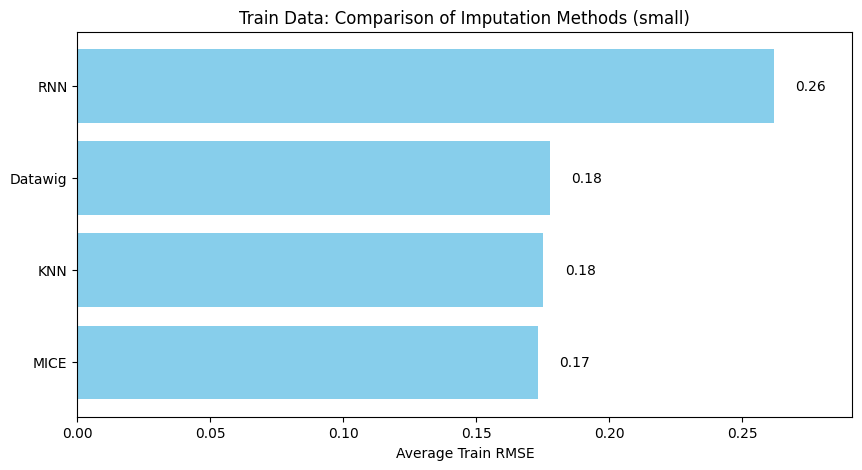

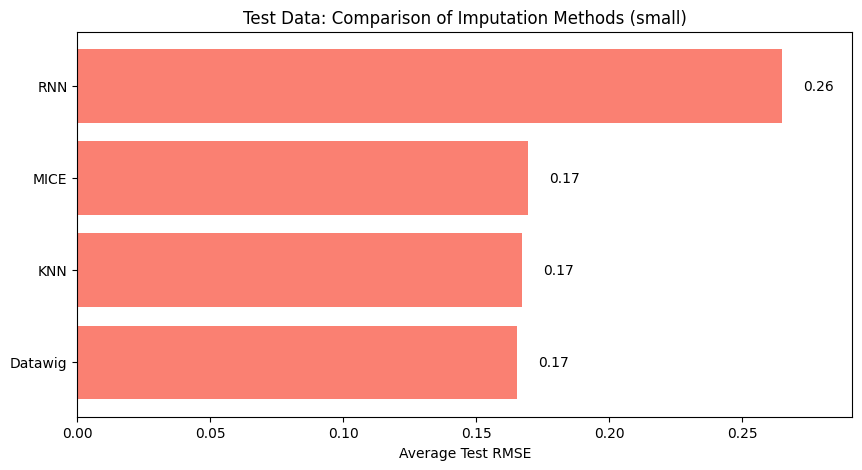

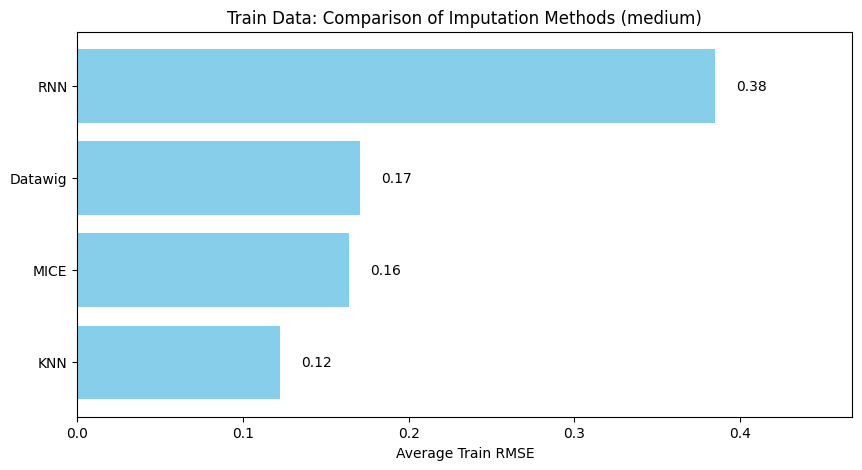

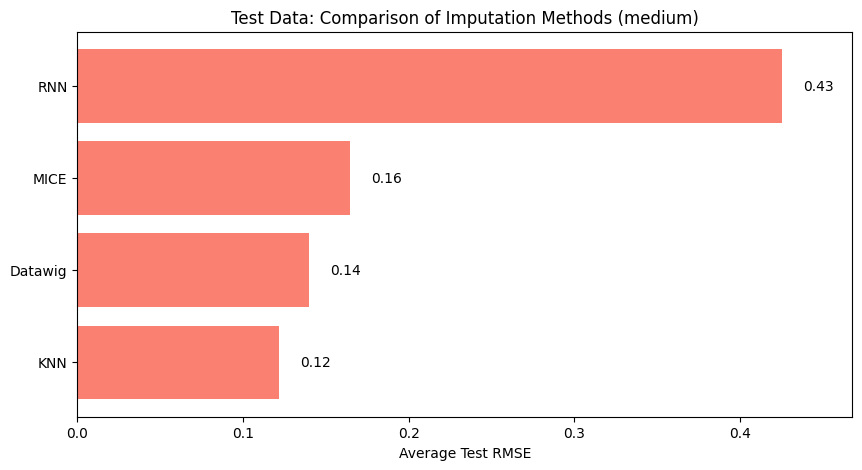

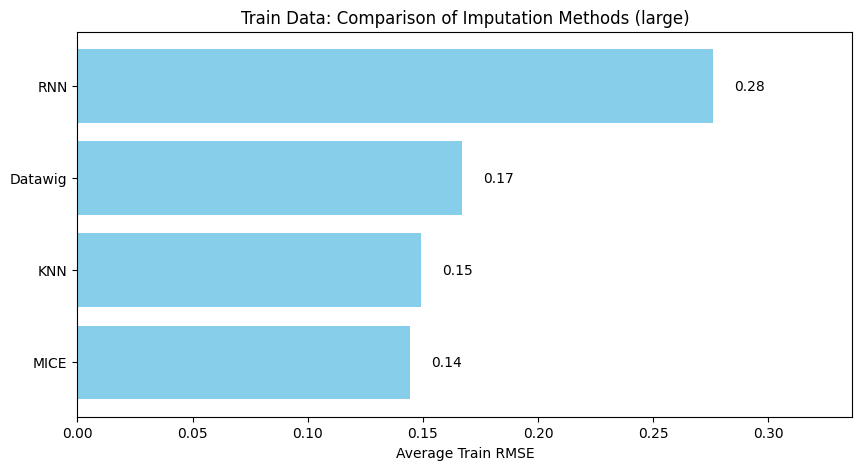

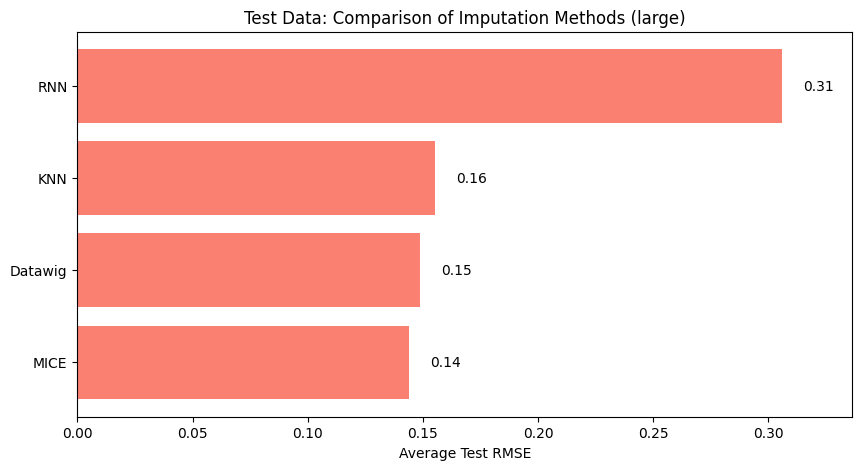

In [7]:
def get_size_category(size):
    """
    Categorizes file size into 'small', 'medium', or 'large' based on predefined thresholds.

    Args:
        size (int): File size in bytes.

    Returns:
        str: Size category ('small', 'medium', or 'large').
    """
    if size < 0.5 * 1024 * 1024:  # Smaller than 1MB
        return 'small'
    elif size < 1 * 1024 * 1024:  # Smaller than 5MB
        return 'medium'
    else:  # Up to 25MB
        return 'large'

def plot_imputation_results_separate(results_folder='cross_miss_results', data_folder='my_datasets'):
    """
    Plots average RMSE values for different imputation methods separately for training and testing data.

    Args:
        results_folder (str, optional): Path to the folder containing imputation results CSV files. Defaults to 'cross_miss_results'.
        data_folder (str, optional): Path to the folder containing datasets. Defaults to 'my_datasets'.

    Returns:
        None
    """
    result_files = glob.glob(os.path.join(results_folder, '*_imputation_results.csv'))
    
    method_results_train = {'small': {}, 'medium': {}, 'large': {}}
    method_results_test = {'small': {}, 'medium': {}, 'large': {}}

    for result_file in result_files:
        filename = os.path.basename(result_file).replace('_imputation_results.csv', '')
        original_file = os.path.join(data_folder, filename)
        file_size = os.path.getsize(original_file)
        size_category = get_size_category(file_size)
        
        df = pd.read_csv(result_file, index_col=0)
        for method in df.columns:
            if method not in method_results_train[size_category]:
                method_results_train[size_category][method] = []
                method_results_test[size_category][method] = []
            method_results_train[size_category][method].append(df.at['train_rmse', method])
            method_results_test[size_category][method].append(df.at['test_rmse', method])
    for size_category in ['small', 'medium', 'large']:
        avg_train = {k: sum(v) / len(v) for k, v in method_results_train[size_category].items() if v}
        avg_test = {k: sum(v) / len(v) for k, v in method_results_test[size_category].items() if v}
        all_values = list(avg_train.values()) + list(avg_test.values())
        max_val = max(all_values) if all_values else 0
        if avg_train:
            sorted_train = sorted(avg_train.items(), key=lambda x: x[1])
            plt.figure(figsize=(10, 5))
            methods, values = zip(*sorted_train)
            bars = plt.barh(methods, values, color='skyblue')
            plt.xlim(0, max_val * 1.1)
            plt.xlabel('Average Train RMSE')
            plt.title(f'Train Data: Comparison of Imputation Methods ({size_category})')
            for bar, value in zip(bars, values):
                if value < 0.1:
                    plt.text(value + max_val * 0.03, bar.get_y() + bar.get_height()/2, f"{value:.4f}", va='center')
                else:
                    plt.text(value + max_val * 0.03, bar.get_y() + bar.get_height()/2, f"{value:.2f}", va='center')
            plt.show()
        else:
            print(f"No train data to display for {size_category} size category.")

        if avg_test:
            sorted_test = sorted(avg_test.items(), key=lambda x: x[1])
            plt.figure(figsize=(10, 5))
            methods, values = zip(*sorted_test)
            bars = plt.barh(methods, values, color='salmon')
            plt.xlim(0, max_val * 1.1)
            plt.xlabel('Average Test RMSE')
            plt.title(f'Test Data: Comparison of Imputation Methods ({size_category})')
            for bar, value in zip(bars, values):
                if value < 0.1:
                    plt.text(value + max_val * 0.03, bar.get_y() + bar.get_height()/2, f"{value:.4f}", va='center')
                else:
                    plt.text(value + max_val * 0.03, bar.get_y() + bar.get_height()/2, f"{value:.2f}", va='center')
            plt.show()
        else:
            print(f"No test data to display for {size_category} size category.")

plot_imputation_results_separate('cross_miss_results', 'my_datasets')